In [9]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
DATA_PATH = ''
#HISTORY_PATH = "Voter_History_{0}"
PREPROCESSED_PATH = "preprocessed/{0}/florida_processed_{0}.csv"
COUPLES_PATH="couples/{0}/couples_{1}_{0}.csv"
#COUPLES_PATH="couples/{0}/couples_FLA_{0}.csv"

In [4]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--old', dest='old_date', action='store', type=str, help='old date value')
parser.add_argument('--new', dest='new_date', action='store', type=str, help='new date value')
parser.add_argument('--county', dest='county', action='store', type=str, help='county')

args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--old OLD_DATE] [--new NEW_DATE]
                             [--county COUNTY]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/rahullachh/.local/share/jupyter/runtime/kernel-e2bbfc31-01e4-4e8b-8741-da1c0b1c1a56.json


SystemExit: 2

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
#preprocessed_date = args.new_date
preprocessed_date = str(20190910)

In [6]:
# couples_date = args.old_date
# county = args.county
county = "DAD"
couples_date = str(20180313)

In [7]:
image_file_prefix = couples_date + "_" + preprocessed_date + "_" + county
stat_file_prefix =  couples_date + "_" + preprocessed_date + "_" + county

import os
if not os.path.exists("plots/" + image_file_prefix):
    os.makedirs("plots/" + image_file_prefix)

if not os.path.exists("stats/" + stat_file_prefix):
    os.makedirs("stats/" + stat_file_prefix)
    
stat_file_path = "stats/" + stat_file_prefix + "/"

In [10]:
global_df = pd.read_csv(PREPROCESSED_PATH.format(preprocessed_date) , sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# global_df.isnull().sum()

In [12]:
global_df.head()

,county_code,voter_id,last_name,first_name,residence_addr_line_1,residence_addr_line_2,residence_city,residence_zipcode,gender,race,birth_date,registration_date,party_affiliation,precinct,voter_status,age,residence_zipcode_5,residence_zipcode_4,uniq_addr
0,ALA,100419592,martin,william,3814 nw 266th st,NaN,newberry,32669,M,5,03/03/1972,03/19/1990,REP,6,ACT,47,32669,NaN,3814 nw 266th st newberry 32669
1,ALA,102146497,whitney,clinton,14116 se 202nd ter,NaN,hawthorne,32640,M,5,06/25/1981,03/08/2001,NPA,8,ACT,38,32640,NaN,14116 se 202nd ter hawthorne 32640
2,ALA,102183223,mulaiya,doodnauth,2296 nw 147th st,NaN,newberry,32669,M,2,06/01/1941,11/01/2001,DEM,49,ACT,78,32669,NaN,2296 nw 147th st newberry 32669
3,ALA,102097818,thalmann,michael,28524 n county road 1491,NaN,alachua,32615,M,5,11/26/1971,09/18/2000,REP,53,ACT,47,32615,NaN,28524 n county road 1491 alachua 32615
4,ALA,102078033,wack,angela,1214 nw 89th ter,NaN,gainesville,32606,F,5,05/04/1978,07/03/2000,DEM,56,ACT,41,32606,NaN,1214 nw 89th ter gainesville 32606


In [13]:
req_cols = ['last_name', 'race', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [14]:
global_df.isnull().sum()

county_code                     0
voter_id                        0
last_name                       0
first_name                      0
residence_addr_line_1           0
residence_addr_line_2    11496956
residence_city                  0
residence_zipcode               0
gender                          0
race                            0
birth_date                      0
registration_date               0
party_affiliation               0
precinct                        0
voter_status                    0
age                             0
residence_zipcode_5             0
residence_zipcode_4      12037566
uniq_addr                       0
dtype: int64

In [15]:
global_df.shape

(14125318, 19)

In [16]:
couples_df = pd.read_csv(COUPLES_PATH.format(couples_date, county) , sep='\t')

In [17]:
couples_df[["uniq_addr"]].head()

,uniq_addr
0,2700 nw 87th ave doral 33172
1,2700 d nw 87th ave doral 33172
2,19138 nw 77th pl hialeah 33015
3,2216 ne 41st ave homestead 33033
4,14305 sw 106th ct miami 33176


## Collecting Addresses of voters

In [18]:
addr_df=global_df[['uniq_addr','voter_id']] 

In [19]:
couples_df_found = pd.merge(couples_df, addr_df, left_on=["voter_id_L"], right_on=["voter_id"], suffixes=["","_L"])

### Removing extra column generated of voter id

In [20]:
del couples_df_found['voter_id']

In [21]:
couples_df_found = pd.merge(couples_df_found, addr_df, left_on=["voter_id_R"], right_on=["voter_id"], suffixes=["","_R"])

### Removing extra column generated of voter id

In [22]:
del couples_df_found['voter_id']

In [23]:
couples_df_found[["voter_id_L","voter_id_R", "uniq_addr_L","uniq_addr_R"]].head()

,voter_id_L,voter_id_R,uniq_addr_L,uniq_addr_R
0,116102121,123618787,2700 nw 87th ave doral 33172,2700 nw 87th ave doral 33172
1,110160350,123667774,2700 d nw 87th ave doral 33172,2700 d nw 87th ave doral 33172
2,116453274,116460172,19138 nw 77th pl hialeah 33015,19138 nw 77th pl hialeah 33015
3,110198247,110294952,2216 ne 41st ave homestead 33033,2216 ne 41st ave homestead 33033
4,109252280,109283319,14305 sw 106th ct miami 33176,14305 sw 106th ct miami 33176


In [24]:
couples_df_found['separated'] = couples_df_found.apply(lambda x : x.uniq_addr_L != x.uniq_addr_R, axis=1)

## Separation percentage

In [25]:
couples_df_found['separated'].value_counts()

False    221874
True      30250
Name: separated, dtype: int64

In [26]:
couples_df_found['separated'].value_counts()/couples_df_found['separated'].shape

False    0.880019
True     0.119981
Name: separated, dtype: float64

In [27]:
# couples_df_found.isnull().sum()

In [28]:
couples_df_found.head()

,county_code_L,voter_id_L,last_name_L,first_name_L,residence_addr_line_1_L,residence_addr_line_2_L,residence_city_L,residence_zipcode_L,gender_L,race_L,...,party_affiliation_R,precinct_R,voter_status_R,age_R,residence_zipcode_5_R,residence_zipcode_4_R,age_diff,uniq_addr_L,uniq_addr_R,separated
0,DAD,116102121,sherry,ethan,2700 nw 87th ave,NaN,doral,33172,M,5,...,NPA,100,ACT,28,33172,NaN,0,2700 nw 87th ave doral 33172,2700 nw 87th ave doral 33172,False
1,DAD,110160350,makonnen,betelhem,2700 d nw 87th ave,NaN,doral,33172,F,3,...,NPA,100,ACT,45,33172,NaN,0,2700 d nw 87th ave doral 33172,2700 d nw 87th ave doral 33172,False
2,DAD,116453274,martinez,elda,19138 nw 77th pl,NaN,hialeah,33015,U,9,...,DEM,364,ACT,55,33015,NaN,0,19138 nw 77th pl hialeah 33015,19138 nw 77th pl hialeah 33015,False
3,DAD,110198247,lopez,stephanie,2216 ne 41st ave,NaN,homestead,330335131,F,4,...,NPA,934,ACT,31,33033,NaN,0,2216 ne 41st ave homestead 33033,2216 ne 41st ave homestead 33033,False
4,DAD,109252280,cox,martha,14305 sw 106th ct,NaN,miami,33176,F,3,...,DEM,803,ACT,59,33176,NaN,0,14305 sw 106th ct miami 33176,14305 sw 106th ct miami 33176,False


## Logging total separation percentage in file

In [29]:
stat_file_path

'stats/20180313_20190910_DAD/'

In [30]:
total_separated_couples = couples_df_found[couples_df_found["separated"] == True].shape[0]
with open(stat_file_path + "total_separation_percentage.csv", "w") as f:
    f.write("\t".join(["separated_count", "total_count", "percentage"]) + "\n")
    f.write("\t".join([str(total_separated_couples), str(couples_df_found.shape[0]), str(100.0 * total_separated_couples/couples_df_found.shape[0])]))

## Convert race categorical 

In [31]:
race_codes = {
    1: "American Indian/Alaskan Native",
    2: "Asian/Pacific Islander",
    3: "Black/Not Hispanic",
    4: "Hispanic",
    5: "White",
    6: "Other",
    7: "Mutli-racial",
    9: "Unknown"
}

## Converting race codes to corresponding race-descriptions

In [32]:
def race_code_lambda(row, subscript):
    if pd.isnull(row["race_" + subscript]):
        return None
    code = int(row["race_" + subscript])
    return race_codes[code]

## Creating descriptive race columns is a time consuming process

In [33]:
couples_df_found["race_desc_L"] = couples_df_found.apply(lambda x: race_code_lambda(x, "L"), axis=1)
couples_df_found["race_desc_R"] = couples_df_found.apply(lambda x: race_code_lambda(x, "R"), axis=1)

In [34]:
global_df["race_desc"] = global_df["race"].apply(lambda x: race_codes[x])

## Feature wise separation percentage

In [35]:
cols = ["party_affiliation", "gender", "race_desc"]
unique_dic = {}
for c in cols:
    unique_dic[c] = set(global_df[c].unique())

## Demographic Percentages

In [38]:
party_affiliation_counts = {}
race_counts = {}

party_affiliation_percentages = {}
race_percentages = {}

total = global_df.shape[0]
for cat_value in unique_dic["party_affiliation"]:
    party_affiliation_counts[cat_value] = global_df[global_df["party_affiliation"] == cat_value].shape[0]
    party_affiliation_percentages[cat_value] = 100.0 * global_df[global_df["party_affiliation"] == cat_value].shape[0]/total

for cat_value in unique_dic["race_desc"]:
    race_counts[str(cat_value)] = global_df[global_df["race_desc"] == cat_value].shape[0]
    race_percentages[str(cat_value)] =  100.0 * global_df[global_df["race_desc"] == cat_value].shape[0]/total

## Thresholding Demographics
For Race we stick to 5% </br>
For Party affiliation we stick to 5%

In [39]:
race_percent_threshold = 5.0
race_other_groups = []
for cat_value in race_percentages:
    if race_percentages[cat_value] <= race_percent_threshold:
        race_other_groups.append(cat_value)

In [40]:
party_percent_threshold = 5.0
party_other_groups = []
for cat_value in party_affiliation_percentages:
    if party_affiliation_percentages[cat_value] <= party_percent_threshold:
        party_other_groups.append(cat_value)

# TODO

In [41]:
# TODO: Implement others mapping into global and couples dataframe
# def create_others_df()

In [42]:
global_df.shape

(14125318, 20)

In [43]:
print(str(unique_dic))

{'party_affiliation': {'NPA', 'REP', 'DEM', 'IND', 'ECO', 'CPF', 'GRE', 'LPF', 'PSL', 'REF'}, 'gender': {'F', 'M', 'U'}, 'race_desc': {'White', 'American Indian/Alaskan Native', 'Black/Not Hispanic', 'Hispanic', 'Mutli-racial', 'Other', 'Unknown', 'Asian/Pacific Islander'}}


## Generate Pair-wise stats by feature
Current focus is only on gender/race/political-affiliation

In [44]:
import time
from itertools import combinations 

def generate_category_based_on_pair_values(first_val, second_val):
    return "({0}, {1})".format(str(first_val), str(second_val))

def generate_pair_stats_by_feature(global_df, couples_df_found, feature, stats={}, others=[]):
    print("Collecting uniques by feature: " + feature)
    unique_vals = list(global_df[feature].unique())
    cat_combinations = list(combinations(list(unique_vals), 2))
    
    stats[feature] = {}
    print("Processing : " + feature + " : Total comb: " + str(len(cat_combinations)))
    i = 0
    start_time = time.time()
    stats[feature]["Other Categories"] = {'count': 0, 'total': 0}
    for comb in cat_combinations:
        first_val = comb[0]
        second_val = comb[1]
        
        left_right = couples_df_found[(couples_df_found[feature + "_L"] == first_val) & (couples_df_found[feature + "_R"] == second_val)]
        right_left = couples_df_found[(couples_df_found[feature + "_L"] == second_val) & (couples_df_found[feature + "_R"] == first_val)]
        
        count = left_right[left_right["separated"] == True].shape[0]
        count += right_left[right_left["separated"] == True].shape[0]
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        if first_val in others or second_val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += left_right.shape[0] + right_left.shape[0]
            continue
        
        stat["total"] = left_right.shape[0] + right_left.shape[0]
        stat["percent"] = count * 100.0/(left_right.shape[0] + right_left.shape[0])
        
        category = generate_category_based_on_pair_values(first_val, second_val)
        stats[feature][category] = stat
        
        i += 1
        
    print("Total value combinations process: " + str(i) + " Total time (secs): " + str(time.time() - start_time))
    
    print("Processing symmetric combinations: " + feature + " : Total comb: " + str(len(unique_vals)))
    for val in unique_vals:
        subset = couples_df_found[(couples_df_found[feature + "_L"] == val) & (couples_df_found[feature + "_R"] == val)]
        
        count = subset[subset["separated"] == True].shape[0]
        
        if val in others:
            stats[feature]["Other Categories"]["count"] += count
            stats[feature]["Other Categories"]["total"] += subset.shape[0]
            continue
        
        stat = {}
        stat["count"] = count
        
        if count == 0:
            continue
        
        stat["total"] = subset.shape[0]
        stat["percent"] = count * 100.0/(subset.shape[0])
        
        category = generate_category_based_on_pair_values(val, val)
        stats[feature][category] = stat
        
    if len(others) > 0 and stats[feature]["Other Categories"]["count"] > 0:
        stats[feature]["Other Categories"]["percent"] = 100.0 * stats[feature]["Other Categories"]["count"]/stats[feature]["Other Categories"]["total"]
    else:
        del stats[feature]["Other Categories"]
    
    print("Done with processing feature: " + feature)
    
    return stats

In [45]:
stat_file_path

'stats/20180313_20190910_DAD/'

In [46]:
def plot_pairwise_stat_by_feature(feature, stats, total_couples=1):
    feature_stats = stats[feature]
    
    figures, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    
    percent_stats = []
    pair_combinations = []
    totals = []
    
    for pair_comb in feature_stats:
        percent_stats.append(feature_stats[pair_comb]["percent"])
        totals.append(feature_stats[pair_comb]["total"])
        pair_combinations.append(pair_comb)

    plot_df = pd.DataFrame({"percent": percent_stats, "category_combination": pair_combinations, "totals": totals})
    plot_df["category_combination_percentage"] = 100.0*plot_df["totals"]/total_couples
    
    sns.barplot(x="percent", y="category_combination", data=plot_df, ax=axes[0], palette=sns.color_palette("Set2"))
    
    axes[0].set(xlabel="Separation percentage")
    
    #     sns.barplot(x="category_combination_percentage", y="category_combination", palette=sns.color_palette("Set2"), data=plot_df, ax=axes[1])

    #   Pie chart
    labels = pair_combinations
    sizes = plot_df["category_combination_percentage"].tolist()
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=['teal', 'salmon', 'silver', 'lightblue', 'orchid', 'pink', 'lightgreen', 'wheat'])
    axes[1].axis('equal')
    axes[1].set(xlabel="Category percentage out of total couples")
    
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    
    #     axes[0].set_title(feature)
    #     axes[1].set_title(feature + " wise couple proportion")

    #     Writing stats into file
    stat_file_name = feature + "_totalCouples-" + str(total_couples) + ".csv"
    plot_df.to_csv(stat_file_path + stat_file_name+'_'+county, sep="\t")
        
    plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_"+ county +  "_pairwise_stat_" + feature)
    plt.tight_layout()

In [47]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "race_desc", others=race_other_groups)

Processing : race_desc : Total comb: 28
Total value combinations process: 3 Total time (secs): 2.7593870162963867
Processing symmetric combinations: race_desc : Total comb: 8
Done with processing feature: race_desc


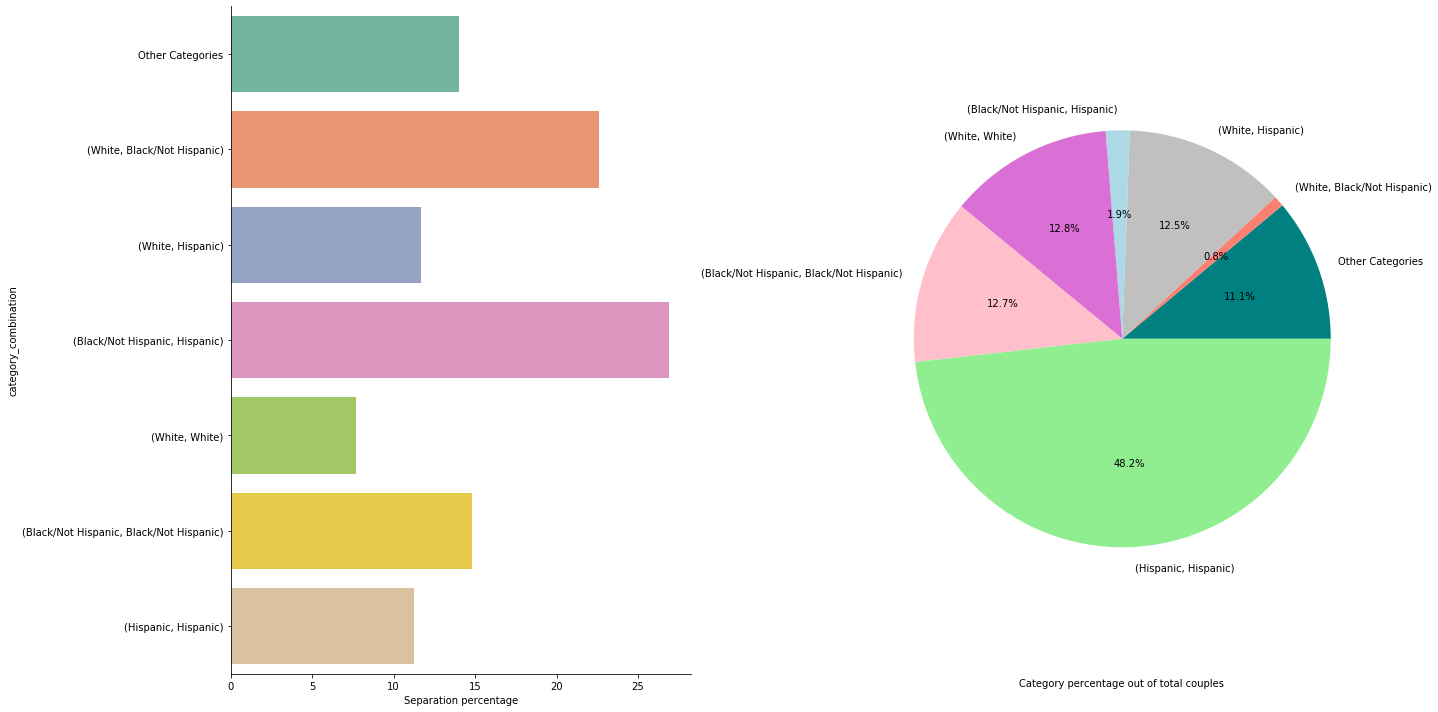

In [48]:
plot_pairwise_stat_by_feature("race_desc", stats, total_couples=couples_df_found.shape[0])

In [49]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "party_affiliation", others=party_other_groups)

Processing : party_affiliation : Total comb: 45
Total value combinations process: 3 Total time (secs): 3.5663859844207764
Processing symmetric combinations: party_affiliation : Total comb: 10
Done with processing feature: party_affiliation


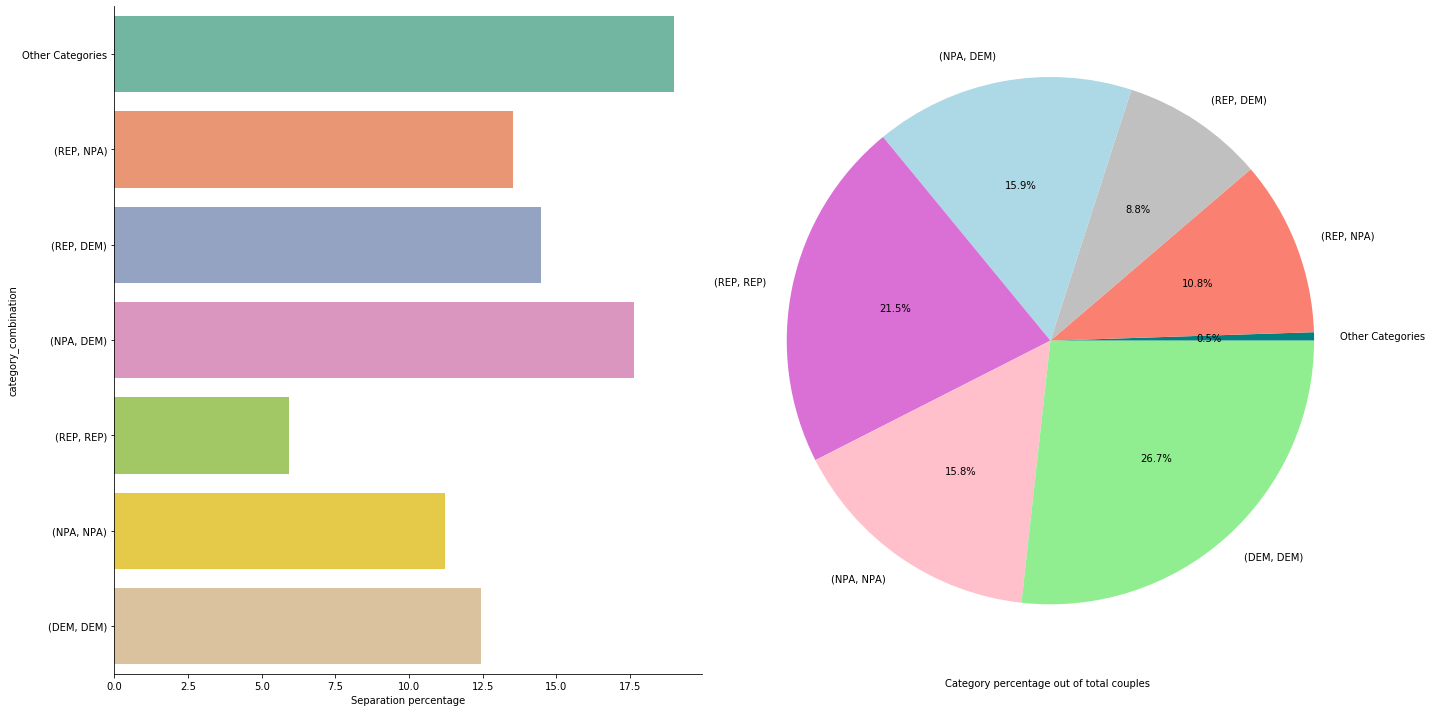

In [50]:
plot_pairwise_stat_by_feature("party_affiliation", stats, total_couples=couples_df_found.shape[0])

In [51]:
stats = generate_pair_stats_by_feature(global_df, couples_df_found, "gender", others=party_other_groups)

Processing : gender : Total comb: 3
Total value combinations process: 3 Total time (secs): 0.4704933166503906
Processing symmetric combinations: gender : Total comb: 3
Done with processing feature: gender


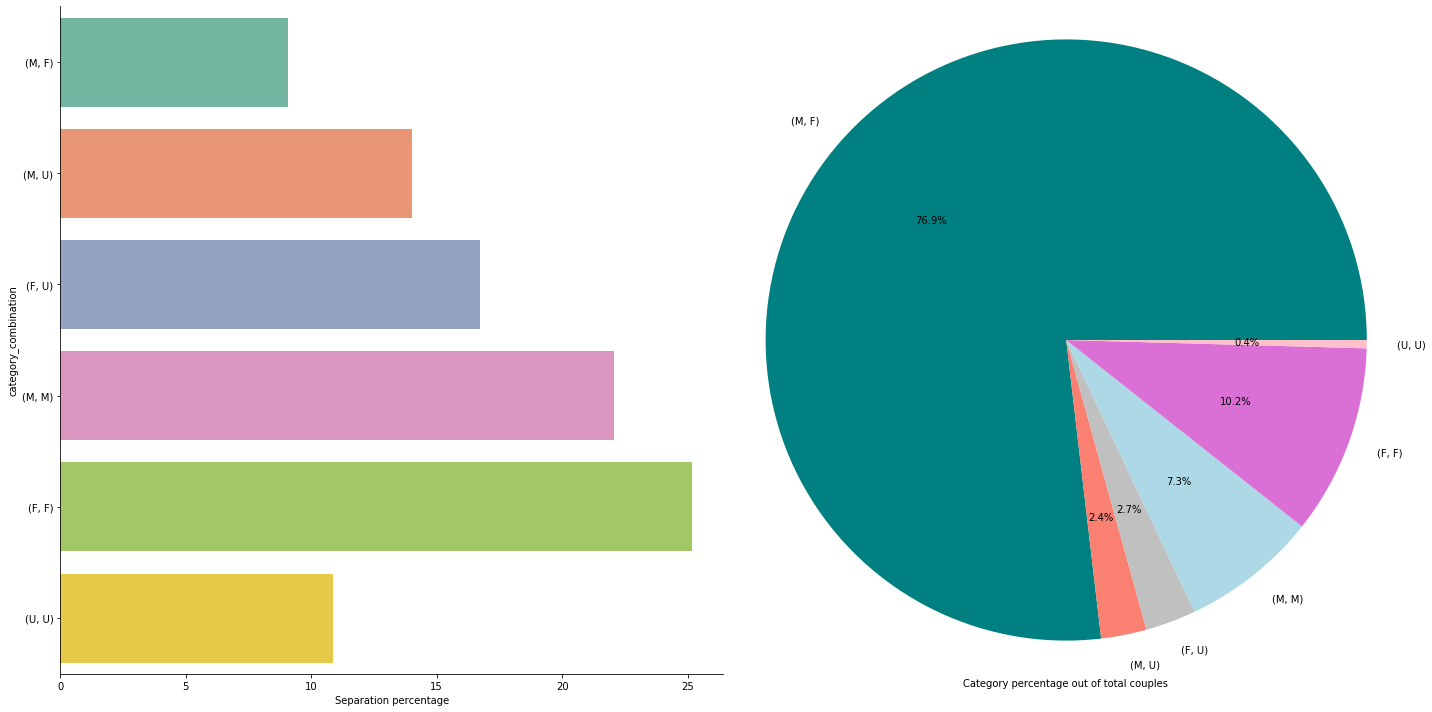

In [52]:
plot_pairwise_stat_by_feature("gender", stats, total_couples=couples_df_found.shape[0])

In [53]:
stats

{'race_desc': {'Other Categories': {'count': 3906,
   'total': 27880,
   'percent': 14.010043041606886},
  '(White, Black/Not Hispanic)': {'count': 476,
   'total': 2104,
   'percent': 22.623574144486692},
  '(White, Hispanic)': {'count': 3691,
   'total': 31587,
   'percent': 11.685186943995948},
  '(Black/Not Hispanic, Hispanic)': {'count': 1261,
   'total': 4684,
   'percent': 26.921434671221178},
  '(White, White)': {'count': 2472,
   'total': 32187,
   'percent': 7.680119302824122},
  '(Black/Not Hispanic, Black/Not Hispanic)': {'count': 4751,
   'total': 32113,
   'percent': 14.79463145766512},
  '(Hispanic, Hispanic)': {'count': 13693,
   'total': 121567,
   'percent': 11.263747563072215}},
 'party_affiliation': {'Other Categories': {'count': 245,
   'total': 1291,
   'percent': 18.977536793183578},
  '(REP, NPA)': {'count': 3666, 'total': 27118, 'percent': 13.51869606903164},
  '(REP, DEM)': {'count': 3195, 'total': 22096, 'percent': 14.459630702389573},
  '(NPA, DEM)': {'count

## Raw code of combination stats (Obsolete)

In [ ]:
# from itertools import combinations
# total_separated = couples_df_found[couples_df_found["separated"] == True].shape[0]
# stats = {}
# for c in cols:
#     cat_combinations = list(combinations(list(unique_dic[c]), 2))
#     stats[c] = {}
#     print("Processing : " + c + " : Total comb: " + str(len(cat_combinations)))
#     i = 0
#     for comb in cat_combinations:
#         first_val = comb[0]
#         second_val = comb[1]
        
#         left_right = couples_df_found[(couples_df_found[c + "_L"] == first_val) & (couples_df_found[c + "_R"] == second_val)]
#         right_left = couples_df_found[(couples_df_found[c + "_L"] == second_val) & (couples_df_found[c + "_R"] == first_val)]
#         count = left_right[left_right["separated"] == True].shape[0]
#         count += right_left[right_left["separated"] == True].shape[0]
#         stats[c][str(first_val) + "_" + str(second_val)] = count
#         stats[c][str(first_val) + "_" + str(second_val) + "_" + "total"] = left_right.shape[0] + right_left.shape[0]
#         i += 1
        
#     print("Done with comb: " + str(i))
    
#     print("Processing symmetric combinations: " + c + " : Total comb: " + str(len(unique_dic[c])))
#     unique_vals = unique_dic[c]
#     for val in unique_vals:
#         subset = couples_df_found[(couples_df_found[c + "_L"] == val) & (couples_df_found[c + "_R"] == val)]
#         count = subset[subset["separated"] == True].shape[0]
#         stats[c][str(val) + "_" + str(val)] = count
#         stats[c][str(val) + "_" + str(val) + "_" + "total"] = subset.shape[0]
    
#     print("Done with processing column: " + c)

## Raw code of plot (Obsolete)

In [ ]:
# figures, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,30))
# race_df = None
# index = 0
# for col in stats:
#     col_stats = stats[col]
#     percent_stats = {}
#     for c in col_stats:
#         if "total" in c:
#             continue
        
#         total = col_stats[c + "_" + "total"]
#         if total == 0:
#             continue
            
#         p = col_stats[c] * 100.0/total
#         if p < 5.0:
#             continue
#         percent_stats[c] = p
    
#     plot_df = pd.DataFrame({"percent": list(percent_stats.values()), "category": list(percent_stats.keys()) })

#     plot_df["percent_str"] = plot_df["percent"].apply(str)
    
# #     sns.barplot(x="category", y="percent", data=plot_df, ax=axes[index])
    
# #     sns.barplot(x="percent_str", y="category", data=plot_df, ax=axes[index])
#     if col == "race":
#         race_df = plot_df
# #         sns.barplot(x="category", y="percent", data=plot_df, ax=axes[index])
#     else:
#         sns.barplot(x="percent", y="category", data=plot_df, ax=axes[index])
#         axes[index].set_title(col)
        

#     index += 1

# plt.tight_layout()

In [ ]:
# sns.barplot(x="percent_round", y="category", data=race_df)

In [54]:
couples_df_found.age_diff.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [55]:
age_diff_total_counts = couples_df_found.groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [56]:
age_diff_total_counts.head()

,age_diff,count
0,0,27816
1,1,46603
2,2,38670
3,3,29438
4,4,23021


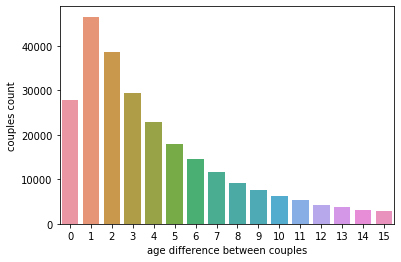

In [57]:
#plt.clear()
plt.close()
ax = sns.barplot(x="age_diff", y="count", data=age_diff_total_counts)
ax.set(xlabel='age difference between couples', ylabel='couples count')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix +"_"+ county+ "_age_diff_aggregation")

In [58]:
age_diff_separation_stats = couples_df_found[couples_df_found["separated"]==True].groupby(["age_diff"])["age_diff"].agg(["count"]).reset_index()

In [59]:
age_diff_separation_stats = pd.merge(age_diff_total_counts, age_diff_separation_stats, on=["age_diff"], suffixes=("_total", "_separated"))

In [60]:
age_diff_separation_stats["percent"] = 100.0 * age_diff_separation_stats["count_separated"]/age_diff_separation_stats["count_total"]

In [61]:
age_diff_separation_stats

,age_diff,count_total,count_separated,percent
0,0,27816,2981,10.716854
1,1,46603,5211,11.181684
2,2,38670,4488,11.605896
3,3,29438,3250,11.040152
4,4,23021,2598,11.285348
5,5,17999,2097,11.650647
6,6,14552,1752,12.039582
7,7,11600,1408,12.137931
8,8,9254,1203,12.999784
9,9,7531,1054,13.995485


In [62]:
age_diff_separation_stats.to_csv(stat_file_path + county+"_age_diff_separation_stats.csv", sep='\t', header=["age_diff", "counts_of_that_age_diff", "separated_count", "separated_percentage"])

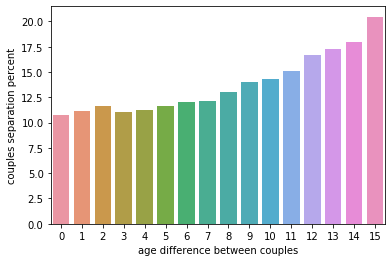

In [63]:
ax = sns.barplot(x="age_diff", y="percent", data=age_diff_separation_stats, )
ax.set(xlabel='age difference between couples', ylabel='couples separation percent')
plt.savefig("plots/" + image_file_prefix + "/" + image_file_prefix + "_"+ county+"_age_diff_separation_percentages")

In [ ]:
# import scipy.stats as stats
# pearson_corr, corr_pvalue = stats.pearsonr(age_diff_separation_stats['age_diff'], age_diff_separation_stats['percent'])
# print('Correlation of Age Diff Vs separation rate: {} \nP_value: {}'.format(pearson_corr, corr_pvalue))

In [ ]:
# cf_polarized = np.where(((couples_df_found["party_affiliation_L"] == "DEM") & (couples_df_found["party_affiliation_R"] == "REP")) |
#                         ((couples_df_found["party_affiliation_L"] == "REP") & (couples_df_found["party_affiliation_R"] == "DEM"))
#                         , 1, 0) 

In [ ]:
# cf_separated = np.where(couples_df_found["separated"] == True, 1, 0)

In [ ]:
#pearson_corr, corr_pvalue = stats.pearsonr(couples_df_stat["no"], couples_df_stat["separation_percent"])
#print('Correlation of Polarized couples (DEM/REP) Vs their separation rate: {} \nP_value: {}'.format(pearson_corr, corr_pvalue))

In [ ]:
# cf_polarized_all = np.where(((couples_df_found["party_affiliation_L"] == "DEM") & (couples_df_found["party_affiliation_R"] == "DEM"))
#                             | ((couples_df_found["party_affiliation_L"] == "REP") & (couples_df_found["party_affiliation_R"] == "REP"))
#                             | ((couples_df_found["party_affiliation_L"] == "NPA") & (couples_df_found["party_affiliation_R"] == "NPA"))
#                         , 0, 1) 

In [ ]:
#pearson_corr, corr_pvalue = stats.pearsonr(cf_polarized_all, cf_separated)
#print('Correlation of Polarized couples Vs their separation rate: {} \nP_value: {}'.format(pearson_corr, corr_pvalue))

In [ ]:
#couples_df_stat = pd.read_csv("stats/20160307_20180313/party_affiliation_totalCouples-2709111.csv" , sep='\t')

In [ ]:
#couples_df_stat.columns = ["no", "separation_percent","cat_comb","total","cat_comb_percent"]

In [ ]:
#couples_df_stat["no"]

In [ ]:
from sklearn.metrics import jaccard_score

In [ ]:
#jaccard_score(cf_polarized_all, cf_separated)  

In [207]:
#pd.crosstab(cf_polarized_all, cf_separated)

In [ ]:
#from sklearn.metrics import matthews_corrcoef
#matthews_corrcoef(cf_separated, cf_polarized_all)

In [ ]:
from scipy.stats import chi2_contingency
#print(chi2_contingency(pd.crosstab(cf_polarized_all, cf_separated)))

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

#cramers_corrected_stat(pd.crosstab(cf_polarized_all, cf_separated))